In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Data Load

In [2]:
path_prate = './prate.sfc.mon.ltm.nc'
path_shum = './shum.mon.ltm.nc'
path_vwnd = './vwnd.mon.ltm.nc'
path_omega = './omega.mon.ltm.nc'

prate_nc=xr.open_dataset(path_prate)
shum_nc=xr.open_dataset(path_shum)
vwnd_nc=xr.open_dataset(path_vwnd)
omega_nc=xr.open_dataset(path_omega)

print(prate_nc)
print(shum_nc)
print(vwnd_nc)
print(omega_nc)

<xarray.Dataset>
Dimensions:             (lat: 94, lon: 192, nbnds: 2, time: 12)
Coordinates:
  * lat                 (lat) float32 88.542 86.6531 ... -86.6531 -88.542
  * lon                 (lon) float32 0.0 1.875 3.75 ... 354.375 356.25 358.125
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    prate               (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes:
    title:                          4x daily NMC reanalysis
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    References:                     http://www.esrl.no

C:\Users\admin\anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
C:\Users\admin\anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: SerializationWarning: Unable

# Data Processing

In [3]:
prate = prate_nc.data_vars['prate']
shum = shum_nc.data_vars['shum']
vwnd = vwnd_nc.data_vars['vwnd']
omega = omega_nc.data_vars['omega']

print(prate.shape) #(time, lat, lon)
print(shum.shape) #(time, level, lat, lon)
print(vwnd.shape)
print(omega.shape)


(12, 94, 192)
(12, 8, 73, 144)
(12, 17, 73, 144)
(12, 12, 73, 144)


In [4]:
#latitude를 찍어보면, 북위90도부터 내림차순으로 배열되어있음.
#따라서 (80, -35)로 설정해야함.
#반대로 (-35, 80)으로 설정하면 latitude dimension이 0이 된다. 

prate = prate.sel(lat=slice(80,-35),lon=slice(240,260))
shum = shum.sel(lat=slice(80,-35),lon=slice(240,260),level=slice(1000,100))
vwnd = vwnd.sel(lat=slice(80,-35),lon=slice(240,260),level=slice(1000,100))
omega = omega.sel(lat=slice(80,-35),lon=slice(240,260),level=slice(1000,100))

In [5]:
#Zonal mean
prate_zm = prate.mean(dim=['lon'])
shum_zm = shum.mean(dim=['lon'])
vwnd_zm = vwnd.mean(dim=['lon'])
omega_zm = omega.mean(dim=['lon'])

print(prate_zm.shape)
print(shum_zm.shape)
print(vwnd_zm.shape)
print(omega_zm.shape)

#print(shum_zm.lat)

(12, 60)
(12, 8, 47)
(12, 12, 47)
(12, 12, 47)


In [7]:
prate_zm = prate_zm * 86400 #Kg/m^2/s
omega_zm = -omega_zm * 1e2

# Visualization

In [13]:
#1. Shum contour 그래프 방법1
def nam_vertical(ax,m=int):
    
    select_month = '0001-0'+str(m)
    
    ax.bar(prate_zm.lat, prate_zm.sel(time=select_month)[0],width=1.5,color='gold')
    plt.xticks(np.arange(-30, 80, 10))
    
    ax1=ax.twinx()
    xs_q, ys_q = np.meshgrid(vwnd_zm.lat, vwnd_zm.level)
    
    U=vwnd_zm.sel(time=select_month)[0]
    V=omega_zm.sel(time=select_month)[0]
    
    ax1.quiver(xs_q, ys_q, U, V, width=0.001, scale=170)
    ax1.invert_yaxis()
    ax1.set_yscale('log')
    
    ax2=ax.twinx()
    shum_contour = ax2.contour(shum_zm.lat, shum_zm.level, shum_zm.sel(time=select_month)[0], levels=10)
    ax2.set_axis_off()
    plt.colorbar(shum_contour, pad = 0.08,label = 'grams/kg')
    
    ax.set_title('NAM vertical month={0}'.format(m))
    ax.set_ylabel('mm/day')
    ax1.set_ylabel('hPa')

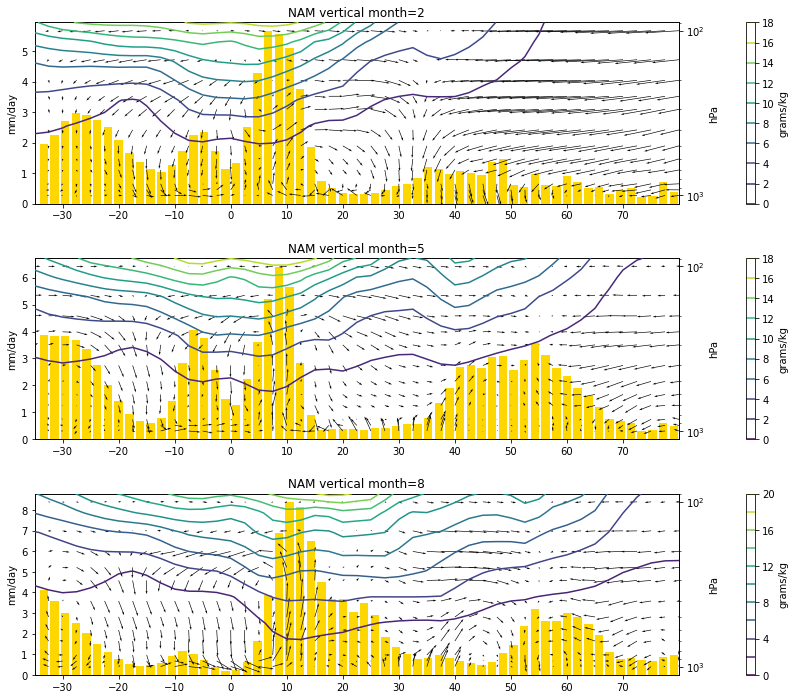

In [14]:
nrow = 3
ncol = 1
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize = (15,12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for i in range(0,3):
    nam_vertical(ax[i],i*3+2)
    
#nam_vertical(ax[0],2)
#nam_vertical(ax[1],5)
#nam_vertical(ax[2],8)

In [15]:
#1. Shum contour 그래프 방법2
def nam_vertical(ax,m=int):
    
    select_month = '0001-0'+str(m)
    
    ax.bar(prate_zm.lat, prate_zm.sel(time=select_month)[0],width=1.5,color='gold')
    plt.xticks(np.arange(-30, 80, 10))
    
    ax1=ax.twinx()
    xs_q, ys_q = np.meshgrid(vwnd_zm.lat, vwnd_zm.level)
    
    U=vwnd_zm.sel(time=select_month)[0]
    V=omega_zm.sel(time=select_month)[0]
    
    ax1.quiver(xs_q, ys_q, U, V, width=0.001, scale=170)
    ax1.invert_yaxis()
    ax1.set_yscale('log')
    
    shum_contour=ax1.contour(shum_zm.lat, shum_zm.level, shum_zm.sel(time=select_month)[0], levels=10)
    #ax1.set_axis_off()
    plt.colorbar(shum_contour, pad = 0.08, label = 'grams/kg')
    
    ax.set_title('NAM vertical month={0}'.format(m))
    ax.set_ylabel('mm/day')
    ax1.set_ylabel('hPa')

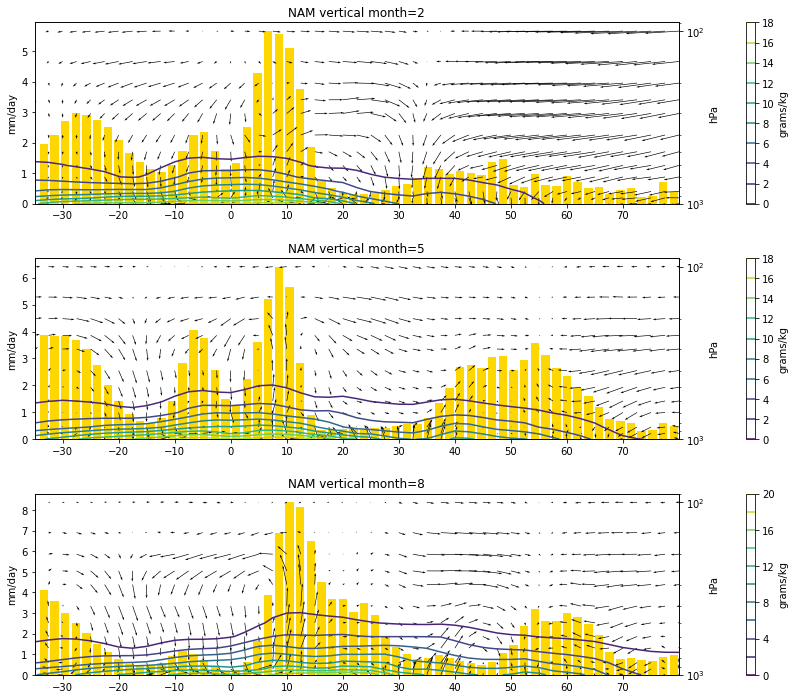

In [16]:
nrow = 3
ncol = 1
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize = (15,12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for i in range(0,3):
    nam_vertical(ax[i],i*3+2)

#nam_vertical(ax[0],2)
#nam_vertical(ax[1],5)
#nam_vertical(ax[2],8)
